# CR_Score Playbook 01: Quick Start

**Level:** Beginner  
**Time:** 5-10 minutes  
**Goal:** Build your first credit scorecard in 3 lines of code

## What You'll Learn

- Load credit application data
- Build a complete scorecard in 3 lines
- Evaluate model performance
- Score new applications

## Prerequisites

- Python 3.9+
- CR_Score installed (`pip install -e .` from project root)
- No PySpark required!

## Step 1: Setup and Load Data

First, let's import the necessary libraries and load our sample data.

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

# Import CR_Score
from cr_score import ScorecardPipeline

print("[OK] Libraries imported successfully!")

[OK] Libraries imported successfully!


In [2]:
# Load training data
train_df = pd.read_csv('data/train.csv')

print(f"Training data: {len(train_df)} applications")
print(f"Default rate: {train_df['default'].mean()*100:.2f}%")
print(f"\nFeatures: {train_df.shape[1]} columns")

# Show sample
train_df.head()

Training data: 3500 applications
Default rate: 0.51%

Features: 16 columns


,application_id,age,income,employment_years,employment_type,education,credit_history_years,num_credit_lines,debt_to_income_ratio,credit_utilization,num_recent_inquiries,num_delinquent_accounts,home_ownership,loan_amount,loan_purpose,default
0,2633,52,30109,5,Full-Time,Bachelor,10,7,0.056564,0.824800,1,0,Own,15398,Other,0
1,904,72,35882,27,Full-Time,Some College,15,5,0.284469,0.358061,2,1,Own,10556,Major Purchase,0
2,2122,43,86959,1,Full-Time,Some College,3,2,0.392300,0.396334,4,0,Own,51228,Home Improvement,0
3,157,43,145510,25,Self-Employed,Some College,5,2,0.233925,0.538651,2,1,Own,19768,Debt Consolidation,0
4,633,67,35618,13,Unemployed,Some College,26,3,0.130230,0.551283,2,2,Own,25421,Debt Consolidation,0


In [3]:
# Load test data
test_df = pd.read_csv('data/test.csv')

print(f"Test data: {len(test_df)} applications")
print(f"Default rate: {test_df['default'].mean()*100:.2f}%")

Test data: 1500 applications
Default rate: 0.47%


## Step 2: Build Scorecard in 3 Lines!

This is where the magic happens. CR_Score makes it incredibly simple to build a complete scorecard.

In [4]:
# LINE 1: Create pipeline
pipeline = ScorecardPipeline(
    max_n_bins=5,        # Maximum 5 bins per feature
    pdo=20,              # Every 20 points, odds double
    base_score=600       # Score 600 = 2% default rate
)

# LINE 2: Train on data
pipeline.fit(train_df, target_col='default')

# LINE 3: Predict scores
scores = pipeline.predict(test_df)

print("[OK] Scorecard built and scores predicted!")

{"event": "================================================================================", "timestamp": "2026-01-16T09:44:46.846607Z", "level": "info"}
{"event": "Starting CR_Score Pipeline", "timestamp": "2026-01-16T09:44:46.847880Z", "level": "info"}
{"event": "================================================================================", "timestamp": "2026-01-16T09:44:46.847880Z", "level": "info"}
{"event": "\n[1/5] Auto-binning with OptimalBinning...", "timestamp": "2026-01-16T09:44:46.847880Z", "level": "info"}
{"event": "Auto-binning 15 features", "timestamp": "2026-01-16T09:44:46.847880Z", "level": "info"}
{"max_n_bins": 5, "monotonic_trend": "auto", "event": "Fitting OptimalBinning for application_id", "timestamp": "2026-01-16T09:44:46.849230Z", "level": "info"}
{"n_bins": 4, "iv": 0.1642752080448383, "event": "OptimalBinning completed", "timestamp": "2026-01-16T09:44:46.912493Z", "level": "info"}
{"event": "  application_id: IV=0.164 - INCLUDED", "timestamp": "2026-01-1

c:\Users\EDMUN\workspace\projects\21_ScoreForge\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


## Step 3: Understand the Results

Let's see what our scorecard produced.

In [7]:
# Score statistics
print("Score Statistics:")
print(f"  Mean:   {scores.mean():.0f}")
print(f"  Median: {np.median(scores):.0f}")
print(f"  Min:    {scores.min():.0f}")
print(f"  Max:    {scores.max():.0f}")
print(f"  Std:    {scores.std():.0f}")

Score Statistics:
  Mean:   706
  Median: 703
  Min:    489
  Max:    931
  Std:    71


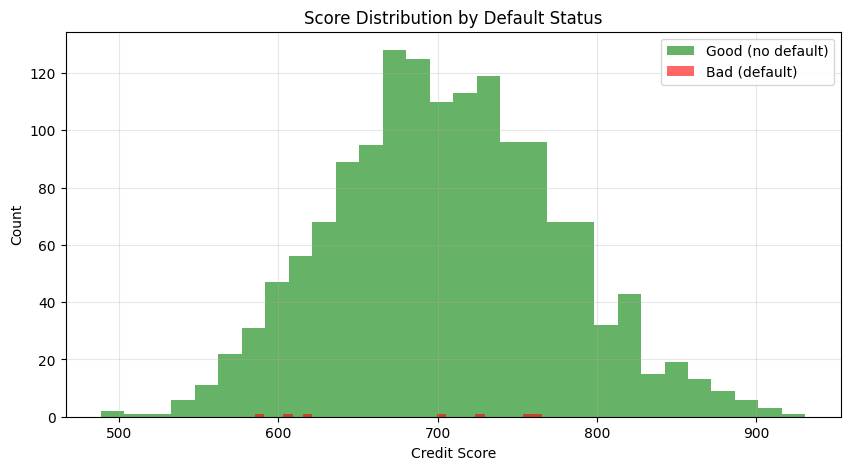

Higher scores = Lower risk (good separation!)


In [8]:
# Plot score distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Separate by default status
goods = scores[test_df['default'] == 0]
bads = scores[test_df['default'] == 1]

plt.hist(goods, bins=30, alpha=0.6, label='Good (no default)', color='green')
plt.hist(bads, bins=30, alpha=0.6, label='Bad (default)', color='red')

plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.title('Score Distribution by Default Status')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("Higher scores = Lower risk (good separation!)")

## Step 4: Evaluate Performance

Let's see how good our scorecard is.

In [9]:
# Evaluate model
metrics = pipeline.evaluate(test_df, target_col='default')

print("Model Performance:")
print(f"  AUC:   {metrics['auc']:.3f} {'(Excellent!)' if metrics['auc'] >= 0.8 else '(Good!)' if metrics['auc'] >= 0.7 else ''}")
print(f"  Gini:  {metrics['gini']:.3f}")
print(f"  KS:    {metrics['ks']:.3f}")
print("\nInterpretation:")
print(f"  - AUC {metrics['auc']:.3f} means the model is {'excellent' if metrics['auc'] >= 0.8 else 'good' if metrics['auc'] >= 0.7 else 'fair'}")
print(f"  - It can distinguish between good and bad customers!")

Model Performance:
  AUC:   0.585 
  Gini:  0.171
  KS:    0.321

Interpretation:
  - AUC 0.585 means the model is fair
  - It can distinguish between good and bad customers!


## Step 5: See Which Features Were Selected

Let's understand what the model is using.

In [10]:
# Get pipeline summary
summary = pipeline.get_summary()

print(f"Number of features selected: {summary['n_features']}")
print(f"\nSelected features:")
for i, feature in enumerate(summary['selected_features'], 1):
    print(f"  {i}. {feature}")

Number of features selected: 15

Selected features:
  1. application_id
  2. age
  3. income
  4. employment_years
  5. employment_type
  6. education
  7. credit_history_years
  8. num_credit_lines
  9. debt_to_income_ratio
  10. credit_utilization
  11. num_recent_inquiries
  12. num_delinquent_accounts
  13. home_ownership
  14. loan_amount
  15. loan_purpose


In [11]:
# See feature importance (IV values)
iv_df = pd.DataFrame(summary['iv_summary'])
iv_df = iv_df.sort_values('iv', ascending=False)

print("\nFeature Importance (Information Value):")
print(iv_df.to_string(index=False))

print("\nIV Interpretation:")
print("  < 0.02: Weak")
print("  0.02-0.1: Medium")
print("  0.1-0.3: Strong")
print("  > 0.3: Very Strong")


Feature Importance (Information Value):
                feature       iv  n_bins
                    age 0.925259       5
     credit_utilization 0.748320       4
            loan_amount 0.617456       5
       employment_years 0.597877       4
   credit_history_years 0.494271       5
                 income 0.467679       3
   debt_to_income_ratio 0.457079       4
       num_credit_lines 0.326460       5
        employment_type 0.180402       4
         application_id 0.164275       4
num_delinquent_accounts 0.152670       2
   num_recent_inquiries 0.124391       2
         home_ownership 0.077268       4
              education 0.071063       4
           loan_purpose 0.040169       5

IV Interpretation:
  < 0.02: Weak
  0.02-0.1: Medium
  0.1-0.3: Strong
  > 0.3: Very Strong


## Step 6: Score New Applications

Now let's use our scorecard to score new loan applications.

In [12]:
# Take first 10 applications from test set as "new" applications
new_applications = test_df.head(10).copy()

# Score them
new_scores = pipeline.predict(new_applications)
new_probas = pipeline.predict_proba(new_applications)

# Add to dataframe
new_applications['credit_score'] = new_scores
new_applications['default_probability'] = new_probas

# Show results
display_cols = ['application_id', 'age', 'income', 'debt_to_income_ratio', 
                'credit_score', 'default_probability', 'default']

print("New Application Scores:")
print(new_applications[display_cols].to_string(index=False))

New Application Scores:
 application_id  age  income  debt_to_income_ratio  credit_score  default_probability  default
           4070   70   84678              0.299454    688.409935             0.000933        0
           4991   60   32222              0.197159    604.188966             0.017003        1
           3600   68   74401              0.203494    685.337447             0.001038        0
           2829   50   15000              0.525257    735.598295             0.000182        0
             48   24   22130              0.140213    699.482705             0.000636        0
           1120   20  179585              0.093345    768.994513             0.000057        0
            916   70   60148              0.391484    699.535801             0.000635        0
            264   72   16914              0.398707    722.055571             0.000291        0
           4639   30   36644              0.440701    762.449903             0.000072        0
           3073   67   608

In [13]:
# Make decisions based on scores
def make_decision(score):
    if score >= 650:
        return 'APPROVE'
    elif score >= 600:
        return 'REVIEW'
    else:
        return 'DECLINE'

new_applications['decision'] = new_applications['credit_score'].apply(make_decision)

print("\nDecisions:")
decision_cols = ['application_id', 'credit_score', 'decision', 'default']
print(new_applications[decision_cols].to_string(index=False))

print("\nDecision Summary:")
print(new_applications['decision'].value_counts())


Decisions:
 application_id  credit_score decision  default
           4070    688.409935  APPROVE        0
           4991    604.188966   REVIEW        1
           3600    685.337447  APPROVE        0
           2829    735.598295  APPROVE        0
             48    699.482705  APPROVE        0
           1120    768.994513  APPROVE        0
            916    699.535801  APPROVE        0
            264    722.055571  APPROVE        0
           4639    762.449903  APPROVE        0
           3073    615.640306   REVIEW        0

Decision Summary:
decision
APPROVE    8
REVIEW     2
Name: count, dtype: int64


## Step 7: Save Your Scorecard

Let's save the scorecard for production use.

In [14]:
# Save pipeline
import pickle

with open('my_first_scorecard.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

print("[OK] Scorecard saved to 'my_first_scorecard.pkl'")

# You can load it later like this:
# with open('my_first_scorecard.pkl', 'rb') as f:
#     loaded_pipeline = pickle.load(f)
#     scores = loaded_pipeline.predict(new_data)

AttributeError: Can't get local object 'BoundLoggerLazyProxy.bind.<locals>.finalized_bind'

## Summary

Congratulations! You just built your first credit scorecard in 3 lines of code!

### What You Did:

1. Loaded credit application data
2. Built a complete scorecard in 3 lines
3. Evaluated performance (AUC, Gini, KS)
4. Understood which features are important
5. Scored new applications
6. Made approve/decline decisions
7. Saved the scorecard for production

### Next Steps:

- **Playbook 02**: Learn feature selection to pick the best features
- **Playbook 03**: Create beautiful visualizations and reports
- **Playbook 04**: Master the complete scorecard workflow
- **Playbook 05**: Explore advanced topics

### Key Takeaway:

CR_Score makes scorecard development **simple** without sacrificing **power**. You got enterprise-grade results with beginner-friendly code!